# Overview

In this post we'll have a look at what's know as **variational inference (VI)**, a family of _approximate_ Bayesian inference methods. In particular, we will focus on one of the more standard VI methods called **Automatic Differentation Variational Inference (ADVI)**.

After having a look at the theory behind VI, we'll show you how you can make use of VI in `Turing`.

# Motivation

In Bayesian inference one usually specifies a model as follows: given data $\left\{ x_i \right\}_{i = 1}^n$, 
\begin{equation*}
\begin{split}
  \text{prior:     } \quad z &\sim p(z)  \\
  \text{likelihood:} \quad x_i &\overset{\text{i.i.d.}}{\sim} p(x \mid z) \quad  \text{where} \quad i = 1, \dots, n
\end{split}
\end{equation*}
where $\overset{\text{i.i.d.}}{\sim}$ denotes that the samples are identically independently distributed. Our goal in Bayesian inference is then to find the _posterior_
\begin{equation*}
p(z \mid \{ x_i \}_{i = 1}^n) = \prod_{i=1}^{n} p(z \mid x_i)
\end{equation*}
In general one cannot obtain a closed form expression for $p(z \mid \{ x_i \}_{i = 1}^n)$, but one might still be able to _sample_ from $p(z \mid \{ x_i \}_{i = 1}^n)$ with guarantees of converging to the target posterior $p(z \mid \{ x_i \}_{i = 1}^n)$ as the number of samples go to $\infty$, e.g. MCMC.

As you are hopefully already aware, `Turing` provides a lot of different methods with asymptotic exactness guarantees that we can apply to such a problem!

Unfortunately, these unbiased samplers can be prohibitively expensive to run. As the model $p$ increases in complexity, the convergence of these unbiased samplers can slow down dramatically. Still, in the _infinite_ limit, these methods should converge to the true posterior! But infinity is fairly large, like, _at least_ more than 12, so this might take a while. 

In such a case it might be desirable to sacrifice some of these asymptotic guarantees, and instead _approximate_ the posterior using some other model which we'll denote $q(z)$.

There are multiple approaches to take in this case, one of which is **variational inference (VI)**.

# Variational Inference (VI)

In VI, we're looking to approximate $p(z \mid \{ x_i \}_{i = 1}^n )$ using some _approximate_ or _variational_ posterior $q(z)$.

To approximate something you need a notion of what "close" means. In the context of probability densities, a standard such "measure" of closeness is the _Kullback-Leibler (KL) divergence_ though this is far from the only one. The KL-divergence is defined between two densities $q(z)$ and $p(z \mid \{ x_i \}_{i = 1}^n)$ as

\begin{equation*}
\begin{split}
  \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \int \log \bigg( \frac{q(z)}{\sum_{i = 1}^n p(z \mid x_i)} \bigg) q(z) \mathrm{d}{z} \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) - \sum_{i = 1}^n \log p(z \mid x_i) \big] \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(z \mid x_i) \big]
\end{split}
\end{equation*}


It's worth noting that unfortunately the KL-divergence is _not_ a metric/distance in the analysis-sense due to its lack of symmetry. On the other hand, it turns out that minimizing the KL-divergence that it's actually equivalent to maximizing the log-likelihood! [INSERT REF] Also, under reasonable restrictions on the densities at hand,

\begin{equation*}
\mathrm{D_{KL}}\big(q(z), p(z \mid \{x_i\}_{i = 1}^n) \big) = 0 \quad \iff \quad p(z) = p(z \mid \{x_i\}_{i = 1}^n), \quad \forall z
\end{equation*}

Therefore one could (and we will) attempt to approximate $p(z \mid \{x_i\}_{i = 1}^n)$ using a density $q(z)$ by minimizing the KL-divergence between these two!

One can also show that $\mathrm{D_{KL}} \ge 0$, which we'll need later. Finally notice that the KL-divergence is only well-defined when in fact $q(z)$ is zero everywhere where $p(z \mid \{x_i\}_{i = 1}^n)$ is zero, i.e.

\begin{equation*}
\mathrm{supp}\big(q(z)\big) \subseteq \mathrm{supp}\big(p(z \mid x)\big)
\end{equation*}

Otherwise there might be a point $z_0$ such that $p(z_0 \mid \{x_i\}_{i = 1}^n) = 0$, resulting in $\log(q(z) / 0)$ which doesn't make sense!

One major problem: as we can see in the definition of the KL-divergence, we need $p(z \mid \{x_i\}_{i = 1}^n)$ for any $z$ if we want to compute the KL-divergence between this and $q(z)$. We don't have that. The entire reason we even do Bayesian inference is that we don't know the posterior! Cleary this isn't going to work. _Or is it?!_

## Computing $\mathrm{D_{KL}}$ without the posterior

First off, recall that

\begin{equation*}
p(z \mid x_i) = \frac{p(x_i, z)}{p(x_i)}
\end{equation*}

so we can write

\begin{equation*}
\begin{split}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) - \log p(x_i) \big] \\
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big] \\ 
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \log p(x_i)
\end{split}
\end{equation*}

where in the last equality we used the fact that $p(x_i)$ is independent of $z$ and $\mathbb{E}_{z \sim q(z)} [1] = 1$ because densities integrate to one.

Now you're probably thinking "Oh great! Now you've introduced $p(x_i)$ which we _also_ can't compute (in general)!". Woah. Calm down human. Let's do some more algebra. The above expression can be rearranged to

\begin{equation*}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) + \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big]}_{=: \mathrm{ELBO}(q)} = \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big]}_{\text{constant}}
\end{equation*}

See? The left-hand side is _constant_ and, as we mentioned before, $\mathrm{D_{KL}} \ge 0$. What happens if we try to _maximize_ the term we just gave the completely arbitrary name $\mathrm{ELBO}$? Well, if $\mathrm{ELBO}$ goes up while $p(x_i)$ stays constant then $\mathrm{D_{KL}}$ _has to_ go down! That is, the $q(z)$ which _minimizes_ the KL-divergence is the same $q(z)$ which _maximizes_ $\mathrm{ELBO}(q)$:

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) = \underset{q}{\mathrm{argmax}} \ \mathrm{ELBO}(q)
\end{equation*}

where

\begin{equation*}
\begin{split}
\mathrm{ELBO}(q) &:= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big]  \bigg) - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] \\
    &= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] \bigg) + \mathbb{H}\big( q(z) \big)
\end{split}
\end{equation*}

and $\mathbb{H} \big(q(z) \big)$ denotes the [(differential) entropy](https://www.wikiwand.com/en/Differential_entropy) of $q(z)$.

Assuming joint $p(x_i, z)$ and the entropy $\mathbb{H}\big(q(z)\big)$ are both tractable, we can use a Monte-Carlo for the remaining expectation. This leaves us with the following tractable expression

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) \approx \underset{q}{\mathrm{argmax}} \ \widehat{\mathrm{ELBO}}(q)
\end{equation*}
where
\begin{equation*}
\widehat{\mathrm{ELBO}}(q) = \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \log p(x_i, z_k) \bigg) + \mathbb{H} \big(q(z)\big) \quad \text{where} \quad z_k \sim q(z) \quad \forall k = 1, \dots, m
\end{equation*}

Hence, as long as we can sample from $q(z)$ somewhat efficiently, we can indeed minimize the KL-divergence! Neat, eh?

Sidenote: in the case where $q(z)$ is tractable but $\mathbb{H} \big(q(z) \big)$ is _not_, we can use an Monte-Carlo estimate for this term too but this generally results in a higher-variance estimate.

Also, I fooled you real good: the ELBO _isn't_ an arbitrary name, hah! In fact it's an abbreviation for the **expected lower bound (ELBO)** because it, uhmm, well, it's the _expected_ lower bound (remember $\mathrm{D_{KL}} \ge 0$). Yup.

## Maximizing $\widehat{\mathrm{ELBO}}(q)$

Finding the optimal $q$ over _all_ possible densities isn't something we're likely to be able to do. Instead we consider a family of _parameterized_ densities $\mathscr{D}_{\Theta}$ where $\Theta$ denotes the space of possible parameters. Each density in this family $q_{\theta} \in \mathscr{D}_{\Theta}$ is parameterized by a unique $\theta \in \Theta$. Moreover, suppose
1. $q_{\theta}(z)$, i.e. evaluating the probability density $q$ at any point $z$, is differentiable
2. $z \sim q_{\theta}(z)$, i.e. the process of sampling from $q_{\theta}(z)$, is differentiable

(1) is fairly straight-forward, but (2) is a bit tricky. What does it even mean for a _sampling process_ to be differentiable? This is quite an interesting problem in its own right and would require something like a [50-page paper to properly review the different approaches (highly recommended read)](https://arxiv.org/abs/1906.10652).

We're going to make use of a particular such approach which goes under a bunch of different names: _reparametrization trick_, _path derivative_, etc. This refers to making the assumption that all elements $q_{\theta} \in \mathscr{Q}_{\Theta}$ can be considered as reparameterizations of some base density, say $q_0(z)$. That is, if $q_{\theta} \in \mathscr{Q}_{\Theta}$ then

\begin{equation*}
z \sim q_{\theta}(z) \quad \iff \quad z := f_{\theta}(\tilde{z}) \quad \text{where} \quad \tilde{z} \sim q_0(z)
\end{equation*}

for some function $f_{\theta}$ differentiable wrt. $\theta$. So all $q_{\theta} \in \mathscr{Q}_{\Theta}$ are using the *same* reparameterization-function $f$ but each $q_{\theta}$ correspond to different choices of $\theta$ for $f_{\theta}$.

Under this assumption we can differentiate the sampling process by taking the derivative of $f_{\theta}$ wrt. $\theta$, and thus we can differentiate the entire $\widehat{\mathrm{ELBO}}(q_{\theta})$ wrt. $\theta$! With the gradient available we can either try to solve for optimality either by setting the gradient equal to zero or maximize $\widehat{\mathrm{ELBO}}(q_{\theta})$ stepwise by traversing $\mathscr{Q}_{\Theta}$ in the direction of steepest ascent. For the sake of generality, we're going to go with the stepwise approach.

With all this nailed down, we eventually reach the section on **Automatic Differentiation Variational Inference (ADVI)**.

## Automatic Differentiation Variational Inference (ADVI)

So let's revisit the assumptions/simplifications we've made at this point:
1. The variational posterior $q_{\theta}$ is in a parameterized family of densities denoted $\mathscr{Q}_{\Theta}$, with $\theta \in \Theta$.
2. $\mathscr{Q}_{\Theta}$ is a space of _reparameterizable_ densities with $q_0(z)$ as the base-density.
3. The parameterization function $f_{\theta}$ is differentiable wrt. $\theta$.
4. Evaluation of the probability density $q_{\theta}(z)$ is differentiable wrt. $\theta$.
5. $\mathbb{H}\big(q_{\theta}(z)\big)$ is tractable.
6. Evaluation of the joint density $p(x, z)$ is tractable and differentiable wrt. $z$
7. The support of $p(z \mid x)$ is a subspace of the support of $q(z)$: $\mathrm{supp}\big(p(z \mid x)\big) \subseteq \mathrm{supp}\big(q(z)\big)$. I didn't mention this earlier, but it's required for the KL-divergence to be well-defined.


All of these are not necessary to do VI, but they are very convenient and results in a fairly flexible approach. One distribution which has a density satisfying the all of the above assumptions _except_ (7) (we'll get back to this in second) for any tractable and differentiable $p(z \mid \{x_i\}_{i = 1}^n)$ is the good ole' Gaussian/normal distribution:

\begin{equation*}
z \sim \mathcal{N}(\mu, \Sigma) \quad \iff \quad z := \mu + L^T \tilde{z} \quad \text{where} \quad \tilde{z} \sim \mathcal{N}(1_d, I_{d \times d})
\end{equation*}

where $\Sigma = L L^T$, with $L$ obtained from the Cholesky-decomposition. Abusing notation a bit, we're going to write

\begin{equation*}
\theta = (\mu, L) := (\mu_1, \dots, \mu_d, L_{11}, \cdots, L_{1, d}, L_{2, 1}, \dots, L_{2, d}, \cdots, L_{d, 1}, \dots, L_{d, d})
\end{equation*}

With this assumption we finally have a tractable expression for $\widehat{\mathrm{ELBO}}(q_{\mu, L})$! Well, assuming (7) is holds. Since a Gaussian has non-zero probability on the entirety of $\mathbb{R}$, we also require $p(z \mid \{x_i\}_{i = 1}^n)$ to have non-zero probability on all of $\mathbb{R}$!

As a (trivial) example we could apply the approach described above to is the following generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    m &\sim \mathcal{N}(0, 1) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, 1), \quad i = 1, \dots, n
\end{split}
\end{equation*}

In this case $z = m$ and we have the posterior defined $p(m \mid \{x_i\}_{i = 1}^n) = \prod_{i = 1}^n p(x_i \mid m) p(m)$. Then the variational posterior would be

\begin{equation*}
q_{\mu, \sigma} = \mathcal{N}(\mu, \sigma^2)
\end{equation*}

And since prior of $m$, i.e. $\mathcal{N}(0, 1)$, has non-zero probability on the entirety of $\mathbb{R}$, same as $q(m)$, the variational optimization problem is simply

\begin{equation*}
\underset{\mu, \sigma}{\mathrm{argmax}} \ \widehat{\mathrm{ELBO}}(q_{\mu, \sigma})
\end{equation*}

So that's great!

But what about this generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{split}
\end{equation*}

with posterior $p(s, m \mid \{x_i\}_{i = 1}^n) = p(s) p(m \mid s) \prod_{i = 1}^n p(x_i \mid s, m)$ and the mean-field variational posterior $q(s, m)$ will be

\begin{equation*}
q_{\mu_1, \sigma_1, \mu_2, \sigma_2}(s, m) = p_{\mathcal{N}(\mu_1, \sigma_1)}(s) p_{\mathcal{N}(\mu_2, \sigma_2)}(m)
\end{equation*}

where we've denoted the evaluation of the probaility density of a Gaussian as $p_{\mathcal{N}(\mu, \sigma)}(x)$.

Observe that $\mathrm{InverseGamma}(2, 3)$ has non-zero probability only on $\mathbb{R}^{ + } := (0, \infty)$ which is clearly not all of $\mathbb{R}$ like $q(s, m)$ has, i.e.

\begin{equation*}
\mathrm{supp} \big( q(s, m) \big) \not\subseteq \mathrm{supp} \big( p(z \mid \{x_i\}_{i = 1}^n) \big)
\end{equation*}

Recall from the definition of the KL-divergence that when this is the case, the KL-divergence isn't well defined. This gets us to the *automatic* part of ADVI.

## "Automatic"? How?

### Change of variables

If we want to compute the probability of $x$ taking a value in some set $A \subseteq \mathrm{supp} \big( p(x) \big)$, we have to integrate $p(x)$ over $A$, i.e.

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_A p(x) \mathrm{d}x
\end{equation*}

This means that if we have a differentiable bijection $f: \mathrm{supp} \big( q(x) \big) \to \mathbb{R}$ with differentiable inverse $f^{-1}: \mathbb{R} \to \mathrm{supp} \big( p(x) \big)$, we can perform a change of variables

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_{f^{-1}(A)} p \big(f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big| \ \mathrm{d}y
\end{equation*}

where $\mathcal{J}_{f^{-1}}(x)$ denotes the jacobian of $f^{-1}$ evaluted at $x$. Observe that this defines a probability distribution

\begin{equation*}
\mathbb{P}_{\tilde{p}}\big(y \in f^{-1}(A) \big) = \int_{f^{-1}(A)} \tilde{p}(y) \mathrm{d}y
\end{equation*}

since $f^{-1}\big(\mathrm{supp} (p(x)) \big) = \mathbb{R}$ which has probability 1. This probability distribution has *density* $\tilde{p}(y)$ with $\mathrm{supp} \big( \tilde{p}(y) \big) = \mathbb{R}$, defined

\begin{equation*}
\tilde{p}(y) = p \big( f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big|
\end{equation*}

or equivalently

\begin{equation*}
\tilde{p} \big( f(x) \big) = \frac{p(x)}{\big| \det \mathcal{J}_{f}(x) \big|}
\end{equation*}

due to the fact that

\begin{equation*}
\big| \det \mathcal{J}_{f^{-1}}(y) \big| = \big| \det \mathcal{J}_{f}(x) \big|^{-1}
\end{equation*}

### Back to VI

So why is this is useful? Well, we're looking to generalize our approach using a normal distribution to cases where the supports don't match up. How about defining $q(z)$ by

\begin{equation*}
\begin{split}
  \eta &\sim \mathcal{N}(\mu, \Sigma) \\
  z &= f^{-1}(\eta)
\end{split}
\end{equation*}

where $f^{-1}: \mathbb{R} \to \mathrm{supp} \big( p(z \mid x) \big)$ is a differentiable bijection with differentiable inverse. Then $z \sim q(z) \implies z \in \mathrm{supp} \big( p(z \mid x) \big)$ as we wanted. The resulting variational density is

\begin{equation*}
q(z) = p_{\mathcal{N}(\mu, \Sigma)}\big( f(z) \big) \ \big| \det \mathcal{J}_{f}(z) \big|
\end{equation*}

Note that the way we've constructed $q(z)$ here is basically a reverse of the approach we described above. Here we sample from a distribution with support on $\mathbb{R}$ and transform *to* $\mathrm{supp} \big( p(z \mid x) \big)$.

If we want to write the ELBO explicitly in terms of $\eta$ rather than $z$, the first term in the ELBO becomes

\begin{equation*}
\begin{split}
  \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \Bigg[ \log \frac{p\big(x_i, f^{-1}(\eta) \big)}{\big| \det \mathcal{J}_{f^{-1}}(\eta) \big|} \Bigg] \\
  &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \log p\big(x_i, f^{-1}(\eta) \big) \big] - \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \big| \det \mathcal{J}_{f^{-1}}(\eta) \big| \big]
\end{split}
\end{equation*}

The entropy is invariant under change of variables, thus $\mathbb{H} \big(q(z)\big)$ is simply the entropy of the normal distribution which is known analytically. 

Hence, the resulting empirical estimate of the ELBO is

\begin{equation*}
\begin{split}
\widehat{\mathrm{ELBO}}(q) &= \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \Big(\log p\big(x_i, f^{-1}(\eta_k)\big) - \log \big| \det \mathcal{J}_{f^{-1}}(\eta_k) \big| \Big) \bigg) + \mathbb{H} \big(q(z)\big) \\
& \text{where} \quad z_k  \sim \mathcal{N}(\mu, \Sigma) \quad \forall k = 1, \dots, m
\end{split}
\end{equation*}

# ADVI in Turing.jl

In [57]:
using Random
using Bijectors, Turing
using Turing: Variational

Random.seed!(1);

## Simple conjugate model

In [58]:
# generate data
x = randn(1, 2000);

In [59]:
@model model(x) = begin
    s ~ InverseGamma(2, 3)
    m ~ Normal(0.0, sqrt(s))
    for i = 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

model (generic function with 2 methods)

In [60]:
# construct model
m = model(x);

First we produce some samples from the posterior using a MCMC method, which, in constrast to VI, is guaranteed to converge to the *exact* posterior (as the number of samples go to infinity).

We'll produce 10000 samples with 200 steps used for adaptation and a target acceptance rate of 0.65

If you don't understand what "adaptation" or "target acceptance rate" refers to, all you really need to know is that `NUTS` is known to be one of the most accurate and efficient samplers (when applicable) while requiring little to no hand-tuning to work well.

In [61]:
@time samples_nuts = sample(m, NUTS(10000, 200, 0.65));

┌ Info: Found initial step size
│   init_ϵ = 0.05
└ @ Turing.Inference /home/tor/.julia/dev/Turing/src/inference/hmc.jl:365
┌ Info: Finished 200 adapation steps
│   adaptor = StanHMCAdaptor(n_adapts=200, pc=DiagPreconditioner, ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.65, state.ϵ=1.4025683056782543), init_buffer=75, term_buffer=50)
│   τ.integrator = Leapfrog(ϵ=1.4)
│   h.metric = DiagEuclideanMetric([0.000961743, 0.000367839])
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/g9AcH/src/sampler.jl:129
┌ Info: Finished 10000 sampling steps in 2.346009772 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.000961743, 0.000367839]))
│   τ = NUTS{Multinomial,Generalised}(integrator=Leapfrog(ϵ=1.4), max_depth=10), Δ_max=1000.0)
│   EBFMI_est = 3806.6806571698903
│   average_acceptance_rate = 0.7837199882764151
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/g9AcH/src/sampler.jl:137


  4.574701 seconds (9.16 M allocations: 779.672 MiB, 12.22% gc time)


Now let's try VI. The most important function you need to now about to do VI in Turing is `vi`:

In [62]:
?Variational.vi

```
vi(model::Model, alg::VariationalInference)
vi(model::Model, alg::VariationalInference, q::VariationalPosterior)
```

Constructs the variational posterior from the `model` and performs the optimization following the configuration of the given `VariationalInference` instance.


This is a convenience function which takes the `Model` you want to approximate, a `VariationalInference` whose type specifies the method to use and the its fields specify the configuration of the method. 

You can also pass it a variational posterior `q` to optimized instead of the default distribution.

**IMPORTANT:** As of writing, `VariationalInference` is just an alias for `MultivariateDistribution`. This means that when you pass `vi` a `q`, we're assuming that `rand(q, num_samples)` produce samples which are of the same length as there are latent variables in your `Model`. Moreover, right now, the subsequent calls, e.g. `elbo`, are only defined for the particular case of a mean-field Normal.

In the future you'll be able to pass more general variational posteriors `q` for which we will then optimized for the corresponding objective for. STAY TUNED FOLKS!

One implementation of `VariationalInference` is `ADVI`, the method we've explained above:

In [63]:
?Variational.ADVI

```
ADVI(samples_per_step = 1, max_iters = 1000)
```

Automatic Differentiation Variational Inference (ADVI) for a given model.


To perform VI on the model `m` using 1 sample for gradient estimation and taking 1000 gradient steps is then as simple as:

In [64]:
# ADVI
advi = ADVI(1, 1000)
q = vi(m, advi);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 16210011248974319527
└ @ Turing.Variational /home/tor/.julia/dev/Turing/src/variational/VariationalInference.jl:150
[ADVI] Optimizing...100% Time: 0:00:03


In [65]:
q.transform.bs

(Bijectors.Exp(), Inversed{Identity}(Identity()))

In [66]:
q.dist

Turing.Core.TuringDiagNormal{Array{Float64,1},Array{Float64,1}}(m=[0.0441737, -0.0159169], σ=[0.0325809, 0.0273169])

Unfortunately, for such a small problem Turing's new `NUTS` sampler is *so* efficient now that we can't even beat it using ADVI! So, so very unfortunate...

With that being said, this is not the case in general. For very complex models we'll later find that `ADVI` produces very reasonable results in a much shorter time than `NUTS`.

And one significant advantage of using `vi` is that we can sample from it with easee. In fact, the result of the `vi` call is a `TransformedDistribution` from Bijectors.jl, and

In [67]:
q isa MultivariateDistribution

true

it implements the Distributions.jl interface for a `Distribution`! This means that we can call `rand` to sample from the variational posterior `q`:

In [68]:
rand(q)

2-element Array{Float64,1}:
  1.0073992279743593 
 -0.04929607999957081

Let's check the first and second moments of the data to see how our above sample from `q` compares:

In [69]:
var(x), mean(x)

(1.0460764393684343, -0.0198997096546508)

That's pretty close! But we're Bayesian so we're not interested in just matching the expected value.

Let's instead look at the entire distribution of our variational posterior `q`. For that we need samples:

In [70]:
@time samples = rand(q, 10000);

  0.015454 seconds (60.90 k allocations: 5.965 MiB, 79.44% gc time)


As you can see, when `q` has already been optimized, sampling from it is a breeze.

In [71]:
# setup for plotting
using Plots, StatsPlots, LaTeXStrings

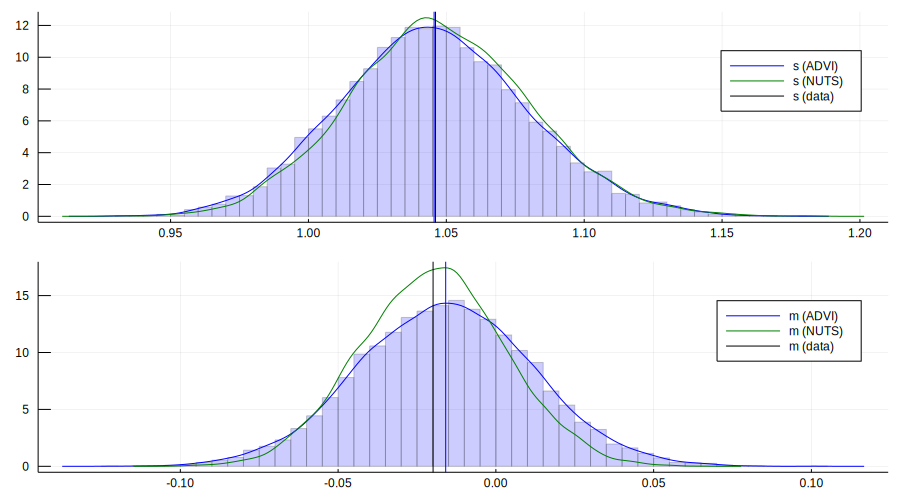

In [72]:
p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green)
vline!([var(x)], label = "s (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green)
vline!([mean(x)], color = :black, label = "m (data)")
vline!([mean(samples[2, :])], color = :blue, label="")

plot(p1, p2, layout=(2, 1), size=(900, 500))

For this particular `Model`, we can in fact obtain the posterior of the latent variables in closed form. 

Let's compare it to the actual posterior of the our model.

In [73]:
# used to compute closed form expression of posterior
using ConjugatePriors

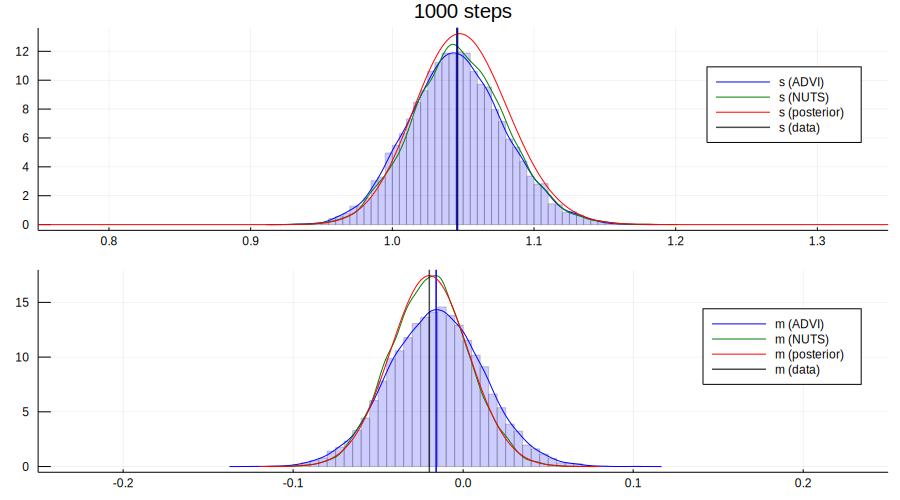

In [74]:
# closed form computation
# notation mapping has been verified by explicitly computing expressions
# in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
μ₀ = 0.0 # => μ
κ₀ = 1.0 # => ν, which scales the precision of the Normal
α₀ = 2.0 # => "shape"
β₀ = 3.0 # => "rate", which is 1 / θ, where θ is "scale"

# prior
pri = NormalGamma(μ₀, κ₀, α₀, β₀)

# posterior
post = posterior(pri, Normal, x)

# marginal distribution of τ = 1 / σ²
# Eq. (90) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
# `scale(post)` = θ
p_τ = Gamma(post.shape, scale(post))
p_σ²_pdf = z -> pdf(p_τ, 1 / z) # τ => 1 / σ² 

# marginal of μ
# Eq. (91) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
p_μ = TDist(2 * post.shape)

μₙ = post.mu    # μ → μ
κₙ = post.nu    # κ → ν
αₙ = post.shape # α → shape
βₙ = post.rate  # β → rate

# numerically more stable but doesn't seem to have effect; issue is probably internal to
# `pdf` which needs to compute ≈ Γ(1000) 
p_μ_pdf = z -> exp(logpdf(p_μ, (z - μₙ) * exp(- 0.5 * log(βₙ) + 0.5 * log(αₙ) + 0.5 * log(κₙ))))

# posterior plots
p1 = plot();
histogram!(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green)
vline!([mean(samples[1, :])], linewidth = 1.5, color = :blue, label ="")

# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.001
r = 0.75:0.001:1.50
norm_const = sum(p_σ²_pdf.(r) .* Δ)
plot!(r, p_σ²_pdf, label = "s (posterior)", color = :red);
vline!([var(x)], label = "s (data)", linewidth = 1.5, color = :black, alpha = 0.7);
xlims!(0.75, 1.35);
title!("$(1 * advi.max_iters) steps");

p2 = plot();
histogram!(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green)
vline!([mean(samples[2, :])], linewidth = 1.5, color = :blue, label="")


# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.0001
r = -0.1 + mean(x):Δ:0.1 + mean(x)
norm_const = sum(p_μ_pdf.(r) .* Δ)
plot!(r, z -> p_μ_pdf(z) / norm_const, label = "m (posterior)", color = :red);
vline!([mean(x)], label = "m (data)", linewidth = 1.5, color = :black, alpha = 0.7);

xlims!(-0.25, 0.25);

p = plot(p1, p2; layout=(2, 1), size=(900, 500))

In [38]:
using StatsFuns: softplus, invsoftplus
f = softplus
f⁻¹ = invsoftplus

logexpm1 (generic function with 2 methods)